# Introduction
This notebook is used to explore the dataset we are going to use for the project.

In [50]:
# imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


## Load
We take the season.csv datasets from 2019, 2020, 2021 and 2022 and merge them into one dataset.

In [51]:
base_path = 'data'
file_name = 'season.csv'
type_dict ={
    'LapStartTime': np.float32,
    'LapNumber': np.uint8,
    'LapTime': np.float32,
    'DriverNumber': "category",
    'Compound': "category",
    'TyreLife': np.uint8,
    'TrackStatus': "category",
    'Stint': np.uint8,
    'DistanceToDriverAhead': np.float32,
    'DriverAhead': "category",
    'PitStatus': "category",
    'IsAccurate': np.bool8,
    'Track': "category",
    'AirTemp': np.float32,
    'Humidity': np.float32,
    'Pressure': np.float32,
    'TrackTemp': np.float32,
    'WindDirection': np.float32,
    'WindSpeed': np.float32
    }

In [52]:
df = pd.DataFrame()

for year in range(2019, 2023):
    path = os.path.join(base_path, str(year), file_name)
    df = pd.concat([
        df,
        pd.read_csv(
            path,
            dtype=type_dict,
        )
    ])


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87891 entries, 0 to 23522
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   LapStartTime           87891 non-null  float32 
 1   LapNumber              87891 non-null  uint8   
 2   LapTime                84630 non-null  float32 
 3   DriverNumber           87891 non-null  object  
 4   Compound               87891 non-null  object  
 5   TyreLife               87891 non-null  uint8   
 6   TrackStatus            87891 non-null  object  
 7   Stint                  87891 non-null  uint8   
 8   DistanceToDriverAhead  81436 non-null  float32 
 9   DriverAhead            81436 non-null  object  
 10  PitStatus              87891 non-null  category
 11  IsAccurate             87891 non-null  bool    
 12  Track                  87891 non-null  object  
 13  AirTemp                87871 non-null  float32 
 14  Humidity               87871 non-null 

### Colonne TrackStatus

La colonne TrackStatus contient un ensemble d'entier concaténés. Chaque entier représente un statut de la piste qui à eu lieu au cours du tour :
* 1 : Drapeau vert (piste libre)
* 2 : Drapau jaune (piste partiellement bloquée)
* 4 : Voiture de sécurité
* 5 : Drapeau rouge (interruption de la session)
* 6 : Voiture de sécurité virtuelle
* 7 : Fin de la voiture de sécurité

<AxesSubplot: title={'center': 'Values of the TrackStatus feature'}, xlabel='TrackStatus', ylabel='Count (log)'>

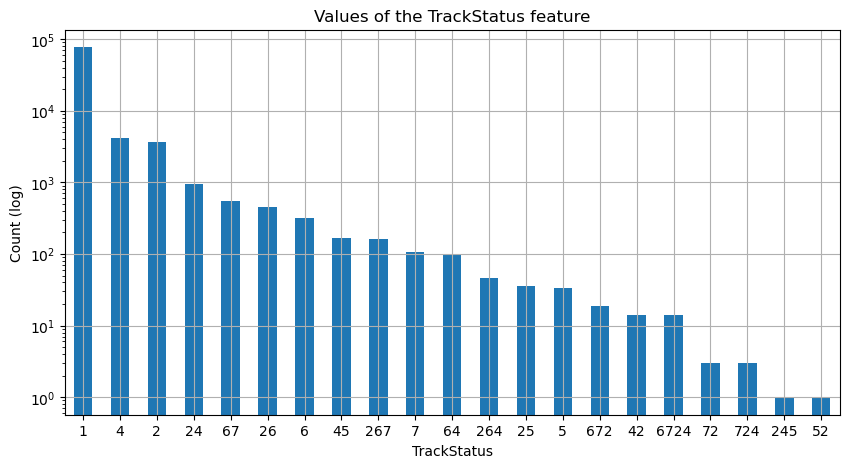

In [54]:
df['TrackStatus'].value_counts().plot(kind='bar', title='Values of the TrackStatus feature', figsize=(10, 5), logy=True, ylabel='Count (log)', xlabel='TrackStatus', grid=True, rot=0)

Pour utiliser cette feature je vais la transformer en 6 features binaires. Chaque feature représente un statut de la piste. Si le statut est présent dans la colonne TrackStatus alors la feature vaut 1 sinon elle vaut 0.

In [55]:
def trackStatus_to_binary(trackStatus):
    status = pd.Series(
        np.zeros(6, dtype=np.bool8),
        index=['Green', 'Yellow', 'SC', 'Red', 'VSC', 'SC_ending']
    )
    if "1" in trackStatus:
        status['Green'] = True
    if "2" in trackStatus:
        status['Yellow'] = True
    if "4" in trackStatus:
        status['SC'] = True
    if "5" in trackStatus:
        status['Red'] = True
    if "6" in trackStatus:
        status['VSC'] = True
    if "7" in trackStatus:
        status['SC_ending'] = True
    return status

trackStatuses = df['TrackStatus'].apply(trackStatus_to_binary)
df = pd.concat([df.drop('TrackStatus', axis=1), trackStatuses], axis=1).reset_index(drop=True)
df[['Green', 'Yellow', 'SC', 'Red', 'VSC', 'SC_ending']].sum().plot(kind='bar', title='Values of the TrackStatus feature', figsize=(10, 5), logy=True, ylabel='Count (log)', xlabel='TrackStatus', grid=True, rot=0)

### Valeurs manquantes
* On remarque que il y a **20** tours ou il n'y a pas de données météo, étant donnée que dans un premier temps on ne va pas utiliser les données météo, on peut les garder.
* Plus problématique, il y a **6'455** tours sans données `DriverAhead` et `DistanceToDriverAhead`. Je suspecte que ça soit les tours de sortie de débuts de course et simplement les tours du pilote leader de la course.
* Il y a également **3'261** tours sans données `LapTime`, je suspecte que ça soit aussi les tours de sortie de débuts de course.

In [58]:
df_cleaning = df[df['DriverAhead'].isna()]
df_cleaning.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6455 entries, 0 to 87875
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   LapStartTime           6455 non-null   float32 
 1   LapNumber              6455 non-null   uint8   
 2   LapTime                4546 non-null   float32 
 3   DriverNumber           6455 non-null   object  
 4   Compound               6455 non-null   object  
 5   TyreLife               6455 non-null   uint8   
 6   Stint                  6455 non-null   uint8   
 7   DistanceToDriverAhead  0 non-null      float32 
 8   DriverAhead            0 non-null      object  
 9   PitStatus              6455 non-null   category
 10  IsAccurate             6455 non-null   bool    
 11  Track                  6455 non-null   object  
 12  AirTemp                6435 non-null   float32 
 13  Humidity               6435 non-null   float32 
 14  Pressure               6435 non-null   

Premièrement, je remarque qu'il y a uniquement **1'909** lignes avec des valeurs manquantes pour `LapTime`, se qui veut dire que **1'352** autres tours n'ont pas de laptime.

<AxesSubplot: title={'center': 'Histogram of Lap n° without a driver ahead'}, xlabel='LapNumber', ylabel='Count'>

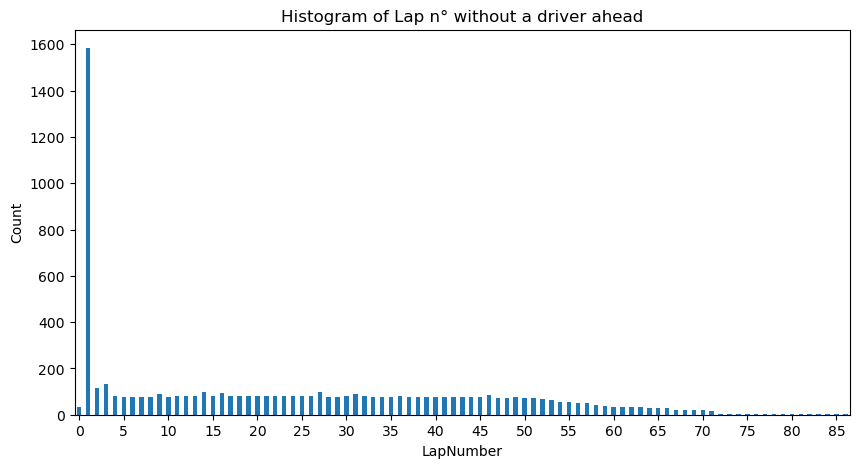

In [59]:
pd.Series(df_cleaning['LapNumber']).value_counts().sort_index().plot(
    kind='bar', 
    figsize=(10, 5), 
    title='Histogram of Lap n° without a driver ahead', 
    xlabel='LapNumber', 
    ylabel='Count',
    xticks=np.arange(
        start=df_cleaning['LapNumber'].min(), 
        stop=df_cleaning['LapNumber'].max(),
        step=5
    ),
    rot=0,
)


Comme attendu, la plupart des lignes avec des valeurs manquantes sont des lignes de début de course avant le 2ème tour. Le reste de la distribution est assez uniforme avec une légère diminution de la fréquence après 55 tours, ce qui est logique car la majorité des courses durent entre 50 et 60 tours.

Je vais donc supprimer les lignes de début de course, c'est à dire les lignes avec `LapNumber` < 2.

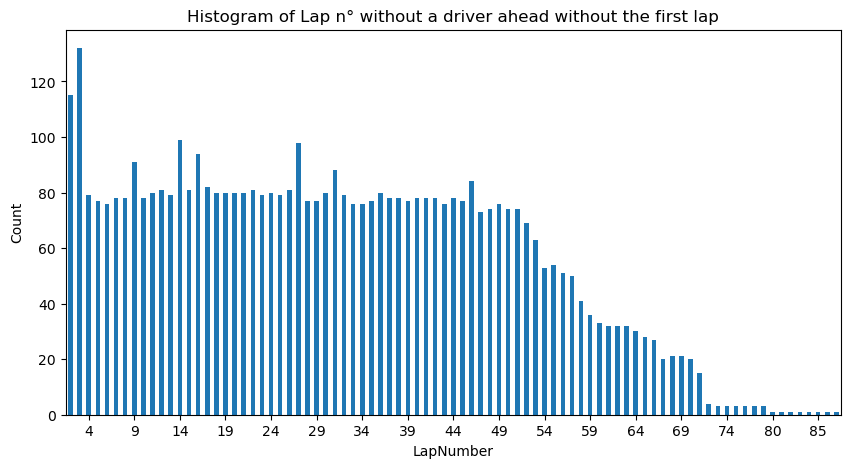

In [60]:
df_cleaning = df_cleaning[df_cleaning['LapNumber'] > 1]

ax = pd.Series(df_cleaning['LapNumber']).value_counts().sort_index().plot(
    kind='bar', 
    figsize=(10, 5), 
    title='Histogram of Lap n° without a driver ahead without the first lap', 
    xlabel='LapNumber', 
    ylabel='Count',
    rot=0,
)

ax.set_xticks(np.arange(
        start=df_cleaning['LapNumber'].min(),
        stop=df_cleaning['LapNumber'].max(),
        step=5
    )
)


In [61]:
df_cleaning.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4839 entries, 20 to 87875
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   LapStartTime           4839 non-null   float32 
 1   LapNumber              4839 non-null   uint8   
 2   LapTime                4546 non-null   float32 
 3   DriverNumber           4839 non-null   object  
 4   Compound               4839 non-null   object  
 5   TyreLife               4839 non-null   uint8   
 6   Stint                  4839 non-null   uint8   
 7   DistanceToDriverAhead  0 non-null      float32 
 8   DriverAhead            0 non-null      object  
 9   PitStatus              4839 non-null   category
 10  IsAccurate             4839 non-null   bool    
 11  Track                  4839 non-null   object  
 12  AirTemp                4839 non-null   float32 
 13  Humidity               4839 non-null   float32 
 14  Pressure               4839 non-null  

On remarque que maintenant que toutes les lignes avec des valeurs manquantes pour `LapTime` ont été supprimées. Les tours sans données `DriverAhead` et `DistanceToDriverAhead` sont maintenant uniquement les tours du pilote leader de la course.

In [62]:
df = df[df['LapNumber'] > 1]

---

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86275 entries, 20 to 87890
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   LapStartTime           86275 non-null  float32 
 1   LapNumber              86275 non-null  uint8   
 2   LapTime                84630 non-null  float32 
 3   DriverNumber           86275 non-null  object  
 4   Compound               86275 non-null  object  
 5   TyreLife               86275 non-null  uint8   
 6   Stint                  86275 non-null  uint8   
 7   DistanceToDriverAhead  81436 non-null  float32 
 8   DriverAhead            81436 non-null  object  
 9   PitStatus              86275 non-null  category
 10  IsAccurate             86275 non-null  bool    
 11  Track                  86275 non-null  object  
 12  AirTemp                86275 non-null  float32 
 13  Humidity               86275 non-null  float32 
 14  Pressure               86275 non-null

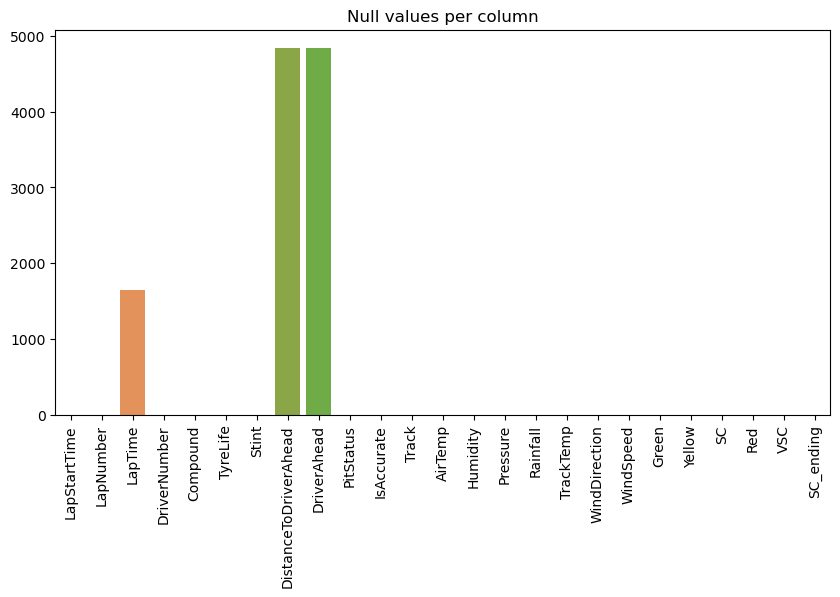

In [63]:
# Bar chart of the null values per column using seaborn
plt.figure(figsize=(10, 5))
sns.barplot(x=df.isna().sum().index, y=df.isna().sum().values)
plt.title('Null values per column')
plt.xticks(rotation=90)
plt.show()


*Il semble qu'au passage, on ait supprimé les lignes avec les valeurs de météo manquantes*

Il reste cependant, **1645** tours sans données pour la colonne 'LapTime`.

In [64]:
df['HasLapTime'] = ~df['LapTime'].isna()

<AxesSubplot: title={'center': 'LapTime null values per TrackStatus'}, xlabel='HasLapTime', ylabel='Count'>

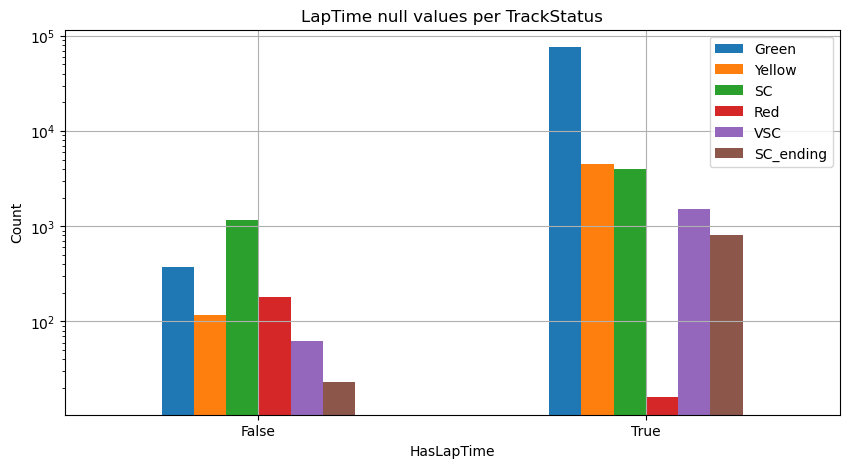

In [69]:
df[['HasLapTime', 'Green', 'Yellow', 'SC', 'Red', 'VSC', 'SC_ending']].groupby('HasLapTime').sum().plot(kind='bar', figsize=(10, 5), title='LapTime null values per TrackStatus', xlabel='HasLapTime', ylabel='Count', rot=0, grid=True, logy=True)

C:\Users\NelsonWork\AppData\Local\Temp\ipykernel_10184\3827230562.py:1: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corrwith(df['HasLapTime']).plot(kind='bar', figsize=(20, 5), title='Correlation with HasLapTime', xlabel='Feature', ylabel='Correlation', grid=True)


<AxesSubplot: title={'center': 'Correlation with HasLapTime'}, xlabel='Feature', ylabel='Correlation'>

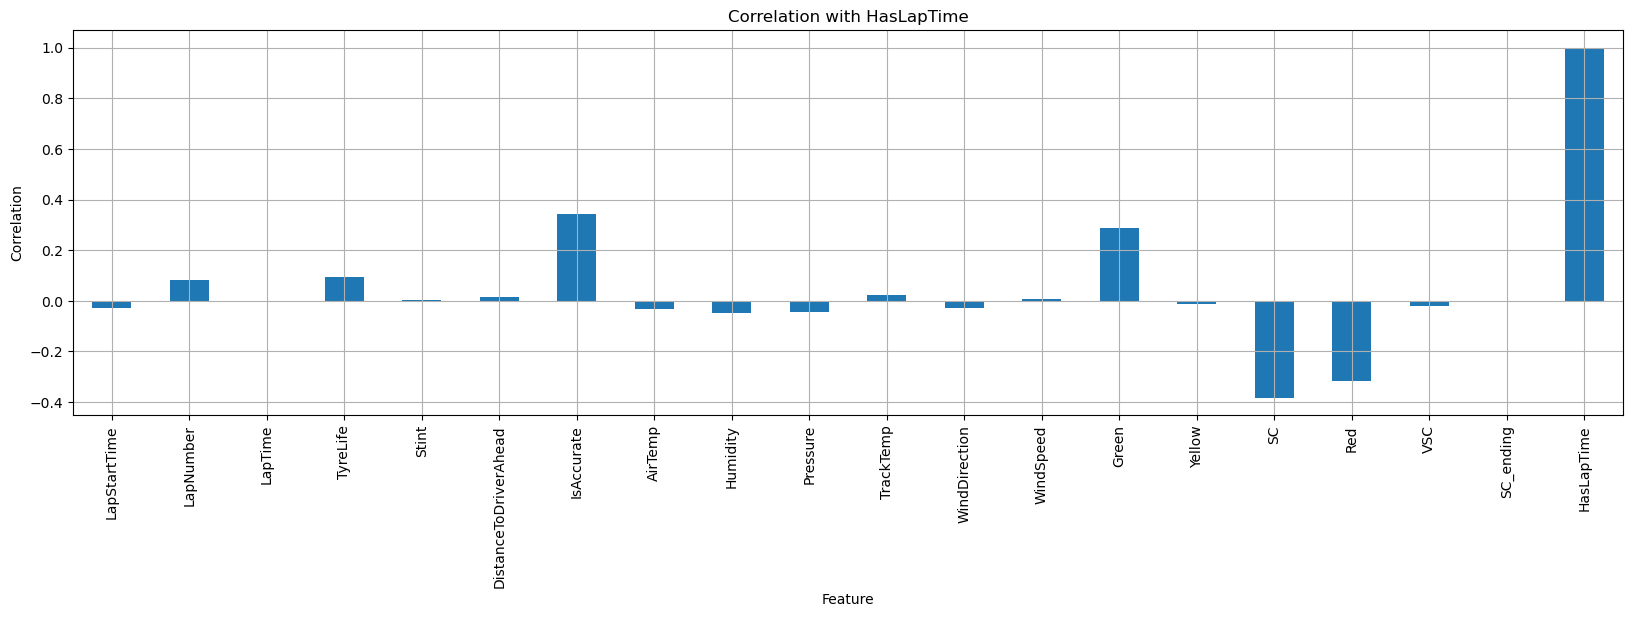

In [72]:
df.corrwith(df['HasLapTime']).plot(kind='bar', figsize=(20, 5), title='Correlation with HasLapTime', xlabel='Feature', ylabel='Correlation', grid=True)

---
Il semble difficile de définir une règle pour remplir les valeurs manquantes. Je vais donc simplement supprimer les lignes avec des valeurs manquantes.

In [85]:
df = df.where(df['HasLapTime'] == True).dropna()
df = df.drop('HasLapTime', axis=1)

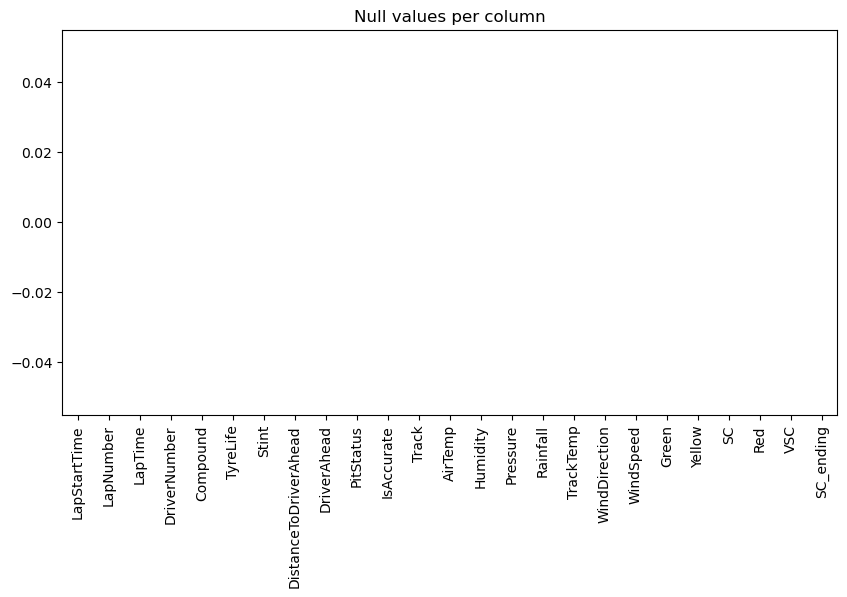

In [89]:
# Bar chart of the null values per column using seaborn
plt.figure(figsize=(10, 5))
sns.barplot(x=df.isna().sum().index, y=df.isna().sum().values)
plt.title('Null values per column')
plt.xticks(rotation=90)
plt.show()